In [32]:
import pandas as pd
import numpy as np
import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

heart_df = pd.read_csv('data/heart.csv')

x = heart_df.iloc[:, :-1]
y = heart_df.iloc[:, -1]
x

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


## Accuracy before data enhancement

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify= y)

x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Skl GBM": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC()
}

for model_name, model in classifiers.items():
    start_time = time.time()
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    total_time = time.time() - start_time

    results = results.append({"Model": model_name,
                              "Accuracy": metrics.accuracy_score(y_test, pred) * 100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_test, pred) * 100,
                              "Time": total_time},
                             ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

,Model,Accuracy,Bal Acc.,Time
1,Random Forest,85.245902,85.010823,0.091998
2,Logistic Regression,85.245902,84.740260,0.002001
3,SVM,85.245902,85.010823,0.002001
4,Skl GBM,83.606557,83.225108,0.050011
5,Decision Tree,78.688525,78.409091,0.001001


## Data Enhancement w/ Standard Deviation

In [68]:
np.random.seed(0)

def data_enhancement(data):
    gen_data = data.copy()

    for cp in data['cp'].unique():
        cp_data = gen_data[gen_data['cp'] == cp]
        trtbps_std = cp_data['trtbps'].std()
        age_std = cp_data['age'].std()
        chol_std = cp_data['chol'].std()
        thalachh_std = cp_data['thalachh'].std()

        for i in gen_data[gen_data['cp'] == cp].index:
            if np.random.randint(2) == 1:
                gen_data['trtbps'].values[i] += trtbps_std/10
            else:
                gen_data['trtbps'].values[i] -= trtbps_std/10
            if np.random.randint(2) == 1:
                gen_data['age'].values[i] += age_std/10
            else:
                gen_data['age'].values[i] -= age_std/10
            if np.random.randint(2) == 1:
                gen_data['chol'].values[i] += chol_std/10
            else:
                gen_data['chol'].values[i] -= chol_std/10
            if np.random.randint(2) == 1:
                gen_data['thalachh'].values[i] += thalachh_std/10
            else:
                gen_data['thalachh'].values[i] -= thalachh_std/10
    return gen_data

gen = data_enhancement(heart_df)

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify= y)

extra_sample = gen.sample(gen.shape[0] // 3)
x_train = pd.concat([x_train, extra_sample.drop(['output'], axis=1)])
y_train = pd.concat([y_train, extra_sample['output']])
y_train

269    0
191    0
15     1
224    0
250    0
      ..
87     1
95     1
174    0
243    0
114    1
Name: output, Length: 343, dtype: int64

## Accuracy with Data Enhancement

In [54]:


x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Skl GBM": GradientBoostingClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC()
}

for model_name, model in classifiers.items():
    start_time = time.time()
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    total_time = time.time() - start_time

    results = results.append({"Model": model_name,
                              "Accuracy": metrics.accuracy_score(y_test, pred) * 100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_test, pred) * 100,
                              "Time": total_time},
                             ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

,Model,Accuracy,Bal Acc.,Time
1,Skl GBM,88.524590,88.041126,0.058709
2,Logistic Regression,88.524590,88.311688,0.003000
3,SVM,88.524590,88.582251,0.005000
4,Decision Tree,86.885246,86.796537,0.001000
5,Random Forest,86.885246,86.796537,0.096021


## Creating new feature

<AxesSubplot:>

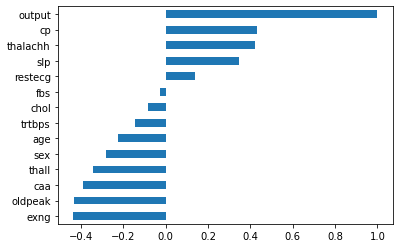

In [56]:
heart_df.corr()['output'].sort_values().plot.barh()
# num_columns = ['trtbps', 'age', 'chol', 'thalachh']

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify= y)

extra_sample = gen.sample(gen.shape[0] // 3)
x_train = pd.concat([x_train, extra_sample.drop(['output'], axis=1)])
y_train = pd.concat([y_train, extra_sample['output']])

x_train = x_train.drop(['exng'], axis=1)
x_test = x_test.drop(['exng'], axis=1)

x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)



results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Skl GBM": GradientBoostingClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC()
}

for model_name, model in classifiers.items():
    start_time = time.time()
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    total_time = time.time() - start_time

    results = results.append({"Model": model_name,
                              "Accuracy": metrics.accuracy_score(y_test, pred) * 100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_test, pred) * 100,
                              "Time": total_time},
                             ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

,Model,Accuracy,Bal Acc.,Time
1,Logistic Regression,88.524590,88.311688,0.002000
2,SVM,86.885246,86.525974,0.005001
3,Random Forest,85.245902,85.010823,0.098050
4,Decision Tree,83.606557,83.225108,0.001000
5,Skl GBM,81.967213,81.709957,0.059013


In [ ]:
np.random.seed(0)

def data_enhancement(data):
    gen_data = data.copy()

    for cp in data['cp'].unique():
        cp_data = gen_data[gen_data['cp'] == cp]
        trtbps_std = cp_data['trtbps'].std()
        age_std = cp_data['age'].std()
        chol_std = cp_data['chol'].std()
        thalachh_std = cp_data['thalachh'].std()

        for i in gen_data[gen_data['cp'] == cp].index:
            if np.random.randint(2) == 1:
                gen_data['trtbps'].values[i] += trtbps_std/10
            else:
                gen_data['trtbps'].values[i] -= trtbps_std/10
            if np.random.randint(2) == 1:
                gen_data['age'].values[i] += age_std/10
            else:
                gen_data['age'].values[i] -= age_std/10
            if np.random.randint(2) == 1:
                gen_data['chol'].values[i] += chol_std/10
            else:
                gen_data['chol'].values[i] -= chol_std/10
            if np.random.randint(2) == 1:
                gen_data['thalachh'].values[i] += thalachh_std/10
            else:
                gen_data['thalachh'].values[i] -= thalachh_std/10
    return gen_data

gen = data_enhancement(heart_df)

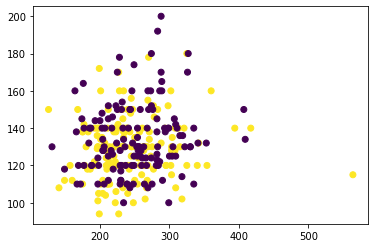

In [90]:
import matplotlib.pyplot as plt
plt.scatter(x['chol'], x['trtbps'], c=y)


In [82]:
x_cb = x.copy()
x_cb['chol * bp'] = x_cb['chol'] * x_cb['trtbps']
x_cb = x_cb.drop(['chol', 'trtbps'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_cb, y, test_size=0.2, random_state=0, stratify= y)

gen['chol * bp'] = gen['chol'] * gen['trtbps']
gen1 = gen.drop(['chol', 'trtbps'], axis =1)

extra_sample = gen1.sample(gen1.shape[0] // 3)
x_train = pd.concat([x_train, extra_sample.drop(['output'], axis=1)])
y_train = pd.concat([y_train, extra_sample['output']])


x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Skl GBM": GradientBoostingClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC()
}

for model_name, model in classifiers.items():
    start_time = time.time()
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    total_time = time.time() - start_time

    results = results.append({"Model": model_name,
                              "Accuracy": metrics.accuracy_score(y_test, pred) * 100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_test, pred) * 100,
                              "Time": total_time},
                             ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

,Model,Accuracy,Bal Acc.,Time
1,Decision Tree,88.524590,88.582251,0.000000
2,Logistic Regression,88.524590,88.311688,0.002017
3,Random Forest,86.885246,86.796537,0.097022
4,Skl GBM,86.885246,86.525974,0.055012
5,SVM,86.885246,86.796537,0.004001
